In [1]:
using DrWatson
@quickactivate "Research"

In [2]:
using Statistics, Plots, LaTeXStrings
pgfplotsx()
theme(:bright)

In [16]:
function load_τs(model, TS, epsilon, L)
    local τs
    try
        fname = savename(@ntuple(model, TS, epsilon, L), "bson"; connector="-")
        fpath = projectdir("results", "meeting", fname)
        @unpack τs = load(fpath)
    catch
        τs = missing
    end
    return τs
end

@unpack model_list, TS_list, epsilon_list_dict, L_list_dict = load(scriptsdir("meeting-sweep.bson"))

results = Dict()
for model in model_list
    epsilon_list = epsilon_list_dict[model]
    L_list = L_list_dict[model]
    res_model = Dict()
    for L in L_list
        res_L = Dict()
        for TS in TS_list
            res_TS = Dict()
            for epsilon in epsilon_list
                τs = load_τs(model, TS, epsilon, L)
                res_TS[epsilon] = τs
            end
            res_L[TS] = res_TS
        end
        res_model[L] = res_L
    end
    results[model] = res_model
end

In [17]:
function find_best(model, L, TS)
    res_L = results[model][L][TS]
    costs = map(τs -> mean(τs) * (L + 2),  values(res_L))
    return minimum(costs)
end

@info find_best("gaussian", 5, "CoupledMultinomialTS{MaximalCoupling}")
@info find_best("lr", 10, "CoupledMultinomialTS{MaximalCoupling}")
@info find_best("coxprocess", 10, "CoupledMultinomialTS{MaximalCoupling}")

# @info find_best("gaussian", 5, "CoupledMultinomialTS{ApproximateOTCoupling}")
# @info find_best("lr", 10, "CoupledMultinomialTS{ApproximateOTCoupling}")
# @info find_best("coxprocess", 10, "CoupledMultinomialTS{ApproximateOTCoupling}")

┌ Info: 247.79999999999998
└ @ Main In[17]:7
┌ Info: 1854.0
└ @ Main In[17]:8
┌ Info: 548.4000000000001
└ @ Main In[17]:9


In [18]:
function make_fig(model, L; save_on=false, label_on=true, makelegend=false, plotsize=(300, 200), skips=[])
    p = plot(size=plotsize)
    
    res_L = results[model][L]

    label_list = ["Metropolis", "Quantile", "Maximal", "OT", "Approx. OT"]
    style_list = [:dot, :dashdotdot, :dash, :solid, :dashdot]
    ms_list = [:diamond, nothing, :star5, :circle, nothing]
    color_list = [1, 2, 3, 4, 5]
    kwargs_shared = (fillalpha=0.2, alpha = 0.7)
    for (TS, label, style, ms, color) in zip(TS_list, label_list, style_list, ms_list, color_list)
        if label in skips
            continue
        end
        markersize = 3
        if makelegend
#             plot!(
#                 p, [1], [1]; 
#                 label=label, style=style, color=color, kwargs_shared...
#             )
            plot!(
                p, [1], [1]; 
                label=label, markershape=ms, color=color, markersize=markersize, kwargs_shared...
            )
        else
            res_TS = res_L[TS]
            epsilon_list = sort(collect(keys(res_TS)))
            τs_list = map(k -> res_TS[k], epsilon_list)
            if any(ismissing.(τs_list))
                idcs = (!).(ismissing.(τs_list))
                println("Missing epsilons: ", epsilon_list[(!).(idcs)])
                epsilon_list = epsilon_list[idcs]
                τs_list = τs_list[idcs]
            end
            μs = map(τs -> mean(τs), τs_list)
            σs = map(τs -> std(τs), τs_list)
#             plot!(
#                 p, epsilon_list, μs; 
#                 label=(label_on ? label : nothing), style=style, color=color, ribbon=σs, kwargs_shared...
#             )
            plot!(
                p, epsilon_list, μs; 
                label=(label_on ? label : nothing), color=color, ribbon=σs, kwargs_shared...
            )
            scatter!(
                p, epsilon_list, μs; label=nothing, markershape=ms, color=color, markersize=markersize, kwargs_shared...
            )

        end
    end
    xlabel!(p, L"\varepsilon")
    ylabel!(p, L"\tau")
    ylims!(0, 1_000 + 50)
    
    if save_on
        fn = "model=$model-L=$L"
        savefig(p, projectdir("plots", "meeting", "$fn.png"))
        savefig(p, projectdir("plots", "meeting", "$fn.pdf"))
        savefig(p, projectdir("plots", "meeting", "$fn.tex"))
    end
    
    p
end
    
skips = ["Quantile", "Approx. OT"]

2-element Array{String,1}:
 "Quantile"
 "Approx. OT"

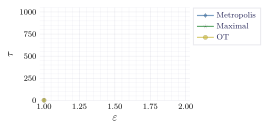

In [19]:
p_legend = make_fig("gaussian", 5; makelegend=true, skips=skips)
savefig(p_legend, projectdir("plots", "meeting", "legend_raw.tex"))

p_legend

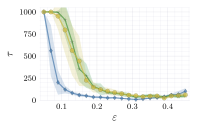

In [20]:
make_fig("gaussian", 5; save_on=true, label_on=false, skips=skips)

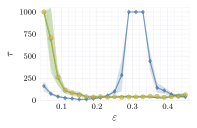

In [21]:
make_fig("gaussian", 10; save_on=true, label_on=false, skips=skips)

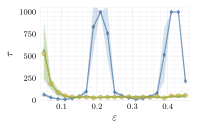

In [22]:
make_fig("gaussian", 15; save_on=true, label_on=false, skips=skips)

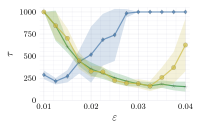

In [23]:
make_fig("lr", 10; save_on=true, label_on=false, skips=skips)

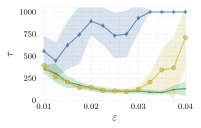

In [24]:
make_fig("lr", 20; save_on=true, label_on=false, skips=skips)

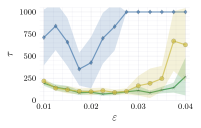

In [25]:
make_fig("lr", 30; save_on=true, label_on=false, skips=skips)

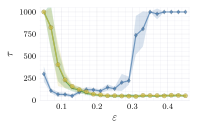

In [26]:
make_fig("coxprocess", 10; save_on=true, label_on=false, skips=skips)

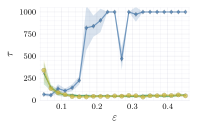

In [27]:
make_fig("coxprocess", 20; save_on=true, label_on=false, skips=skips)

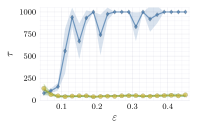

In [28]:
make_fig("coxprocess", 30; save_on=true, label_on=false, skips=skips)